# HW04 Machine Learning Fall 2018 | Part II - Programming | amc1354 & ads798
## Problem 5
### (a) List the 5 tokens that occur most frequently in the training set.

In [1]:
import pandas as pd
from collections import Counter

with open("reviewstrain.txt") as f:
    traindata=[line.split() for line in f]

dataset = pd.DataFrame(data = {'review': [' '.join(traindata[0][1:])], 'label': [int(traindata[0][0])]})
for item in traindata[1:]:
    dataset = dataset.append(pd.DataFrame([[' '.join(item[1:]), int(item[0])]], columns=['review','label']), ignore_index=True)

token_count = Counter(' '.join(dataset['review']).split()).most_common()
print("Top 5 most frequent tokens:\n", token_count[:5])

Top 5 most frequent tokens:
 [('.', 1426), (',', 1349), ('the', 1255), ('a', 938), ('and', 919)]


Obviously, the most frequent tokens are English stopwords and punctuation. One could create a more useful dataset by removing punctuation, English stopwords, and stemming words so we don't have attributes with repeated meaning. E.g., "love", "loved", "loving" would form different attributes. After stemming, they will belong to the same attribute "lov".

### (b) Calculate IG for every attribute and list the 5 attributes with the highest IG

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
import math
import numpy as np
def entropy(var):
    #var is a variable having only 0,1 values
    N_1 = sum(var)
    N = len(var)
    N_0 = N - N_1
    return 0 if N_0==0 or N_1==0 else - N_1/N * math.log(N_1/N, 2) - N_0/N * math.log(N_0/N, 2)

trainingcorpus = dataset['review']

vectorizer = CountVectorizer()
DTM = vectorizer.fit_transform(trainingcorpus)
#Now, to transorm it in an occurrence matrix, where the term is not 0, we put a 1.
npDTM = np.array(DTM.toarray())
npDTM[npDTM != 0] = 1

labels = np.array(dataset['label'])

entropy_label = entropy(labels)

features_IG = pd.DataFrame(data = {'feature': [], 'IG': []})

for column in npDTM.T:
    N_1 = len(labels[column==1])
    N_0 = len(labels[column==0])
    N = N_1 + N_0
    IG = entropy_label - N_1/N * entropy(labels[column==1]) - N_0/N * entropy(labels[column==0])
    features_IG = features_IG.append(pd.DataFrame([["", IG]], columns=['feature','IG']), ignore_index=True)

features_IG['feature'] = vectorizer.get_feature_names()

print(features_IG.sort_values('IG', ascending=False)[:5])

     feature        IG
399      bad  0.025357
487     best  0.020668
5098     too  0.011856
3228  moving  0.011615
225      and  0.010230


### (c) Train Neural Net using only the 50 attributes with highest information gain

In [5]:
import bppy_logloss
import matplotlib.pyplot as plt

k=50
training_top_IG = features_IG.sort_values('IG', ascending=False)[:k]['feature']

I = npDTM[:,training_top_IG.index.values]
D = labels.reshape([-1,1])
n_hidden = 10
eta = 0.1
n_max = 400

w,wb,v,vb,err_curve = bppy_logloss.bp(I,D,n_hidden,eta,n_max)

#predict
with open("reviewstest.txt") as f:
    testdata=[line.split() for line in f]

testdataset = pd.DataFrame(data = {'review': [' '.join(testdata[0][1:])], 'label': [int(testdata[0][0])]})
for item in testdata[1:]:
    testdataset = testdataset.append(pd.DataFrame([[' '.join(item[1:]), int(item[0])]], columns=['review','label']), ignore_index=True)

testcorpus = testdataset['review']

testDTM = vectorizer.fit_transform(testcorpus)
nptestDTM = np.array(testDTM.toarray())
nptestDTM[nptestDTM != 0] = 1

test_features=vectorizer.get_feature_names()
training_features = np.array(training_top_IG)

testI = np.empty((500,0), int)

for feature in training_features:
    if feature in test_features:
        testI = np.append(testI, nptestDTM[:,test_features.index(feature)].reshape([-1,1]), axis=1)
    else:
        testI = np.append(testI, np.zeros(500).reshape([-1,1]), axis=1)


y_pred = np.empty((0,0), int)
for i in range(500):
    x = testI[i,:].reshape([1,-1])
    z = bppy_logloss.sigmoid(x.dot(w)+wb)
    y_pred = np.append(y_pred, 0 if bppy_logloss.sigmoid(z.dot(v)+vb)<=.5 else 1)
    

y_test = pd.Series(testdataset['label'])
y_pred = pd.Series(y_pred)
cm = pd.crosstab(y_pred, y_test, rownames=['Predicted'], colnames=['True'], margins=True)

print("\n Confusion matrix for top {} IG tokens:\n\n".format(k), cm)
print("\n Accuracy = {}%".format(100*(cm[0][0]+cm[1][1])/cm['All']['All']))

ModuleNotFoundError: No module named 'bppy_logloss'

We played with few values of eta (learning rate) and n_max (number of epochs). We noted that for low values of eta, say 0.001, bacward propagation too long (many, many epochs) to find a minimum. Keeping the same number of epochs, 0.1 is a more appropriate learning rate then eta=0.001 or 0.01 as the latter values achieved a lower accuracy. Regarding the number of epochs, we settled at 400 because by looking at the plot above (y shows the mean training error and x shows the no. of epoch) for 1,000 epochs, it looked like plateauing at roughly 400.

### (d) Accuracy achieved by Zero-R

In [7]:
# Apply Zero-R algorithm
y_train = []
for review in traindata:
    y_train.append(int(review[0]))
y_train = pd.Series(y_train)

if sum(y_train==0) <= sum(y_train==1):
    pred_zr = 1
else:
    pred_zr = 0
    
Nt = len(y_test)
y_pred_zr = [pred_zr]*Nt 

print("\n Accuracy using zero-r = {}%".format(100*sum(y_test==y_pred_zr)/Nt))


 Accuracy using zero-r = 54.6%


### (e) Using Top k attributes

It would be reasonable to think that by including more attributes we add more information. Therefore, accuracy should increase as we include more tokens.

The contrary might be reasonable as well: including less attributes lower the computational burden. Moreover, including more attributes means also including more noise so we might need to restructure the network by adding more layers and playing with the no. of nodes per layer to capture the level of complexity of the decision function. Finally, we expect the IG to plateau or approach 0 in the least attributes ranked by IG levels. So there might be a threshold of the number of attributes such that including more does not improve accuracy substantially.

### (f) Experiments With Top k attributes

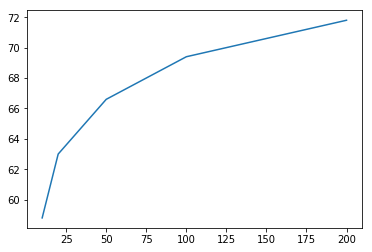

[58.8 63.  66.6 69.4 71.8]


In [9]:
accuracy_curve = np.array([])
for k in [10, 20, 50, 100, 200]:
    
    training_top_IG = features_IG.sort_values('IG', ascending=False)[:k]['feature']

    I = npDTM[:,training_top_IG.index.values]
    D = labels.reshape([-1,1])
    n_hidden = 10
    eta = 0.1
    n_max = 400

    w,wb,v,vb,err_curve = bppy_logloss.bp(I, D, n_hidden, eta, n_max, "no plot")

    training_features = np.array(training_top_IG)

    testI = np.empty((500,0), int)

    for feature in training_features:
        if feature in test_features:
            testI = np.append(testI, nptestDTM[:,test_features.index(feature)].reshape([-1,1]), axis=1)
        else:
            testI = np.append(testI, np.zeros(500).reshape([-1,1]), axis=1)

    y_pred = np.empty((0,0), int)
    for i in range(500):
        x = testI[i,:].reshape([1,-1])
        z = bppy_logloss.sigmoid(x.dot(w)+wb)
        y_pred = np.append(y_pred, 0 if bppy_logloss.sigmoid(z.dot(v)+vb)<=.5 else 1)
    
    y_test = pd.Series(testdataset['label'])
    y_pred = pd.Series(y_pred)
    cm = pd.crosstab(y_pred, y_test, rownames=['Predicted'], colnames=['True'], margins=True)

    accuracy_curve = np.append(accuracy_curve, 100*(cm[0][0]+cm[1][1])/cm['All']['All'])
    
plt.plot([10, 20, 50, 100, 200], accuracy_curve)        
plt.show()

print(accuracy_curve)

The above plot has the accuracy in % on the Y axis and the no. of k top-IG attributes used on the X axis. We expected to see accuracy increasing by including more information. However, we did not expect such a big increase from 50 attributes to 200 (accuracy improves of 5.2 percentage points) as the Nnet we used has just 10 nodes in the middle layers. It would be interesting to plot the ranked IG values to see when and if it has a plateau so to verify how many tokens it is sensible including. 

Regarding difficulties running the experiments, we observed training times increasing with the number of attributes. This is expected as there are many more weights to run GD epochs on. 200 was the limit for running the code on our local laptop in a reasonable time.